In [1]:
import pickle as pk

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from common import *
from util import *

# Load everything


MODEL_NAMES = ["LinearRegression","Feedforward","conv1d","LSTM"]

run_info = {}

for MODEL_NAME in MODEL_NAMES:
    
    RUN_INFO_FILEPATH = model_name_to_run_info_filepath(MODEL_NAME)

    run_info[MODEL_NAME] = (pk.load(open(RUN_INFO_FILEPATH, "rb")))
    
# history_dict = run_info["history"]
# preds = run_info["predictions"]

scaled_data = {}
with np.load(PREPROCESSED_DATASET_FILEPATH) as npz_loader:
    for key in npz_loader.files:
        print("{}: {}".format(key, npz_loader[key].shape))
        scaled_data[key] = npz_loader[key]
scaler = pk.load(open(PREPROCESSING_SCALER_FILEPATH, "rb"))

# Input and output dims
input_shape = tuple(list(scaled_data['x_train'].shape)[1:])
output_shape = tuple(list(scaled_data['y_train'].shape)[1:])
input_dims = np.product(input_shape)
output_dims = np.product(output_shape)

# Load train, val, test data
directory = DATASET_DIRECTORY
data = {}

for split in ['train','val','test']:
    data_split = np.load(os.path.join(directory, split + ".npz"))
    data['x_'+split] = data_split['x']
    data['y_'+split] = data_split['y']

x_train: (23974, 12, 207, 2)
y_train: (23974, 12, 207, 2)
x_val: (3425, 12, 207, 2)
y_val: (3425, 12, 207, 2)
x_test: (6850, 12, 207, 2)
y_test: (6850, 12, 207, 2)


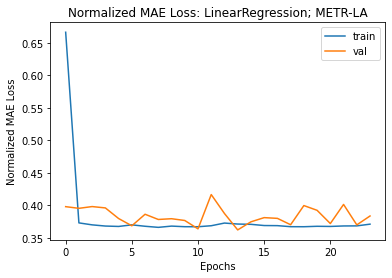

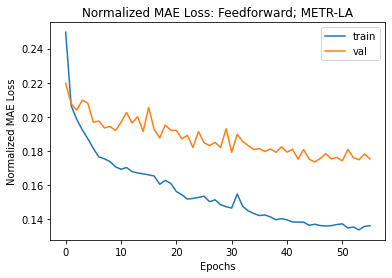

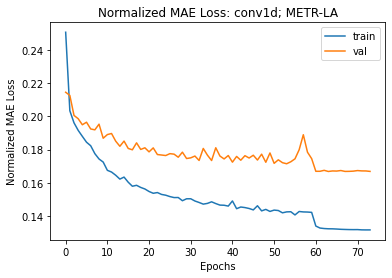

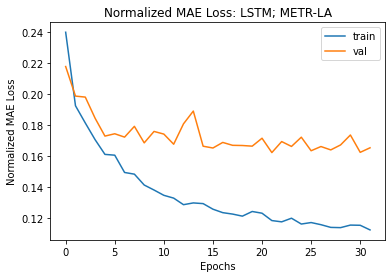

In [2]:
# Plot training and validation loss

for MODEL_NAME in MODEL_NAMES:
    plt.figure()
    plt.title("Normalized MAE Loss: "+MODEL_NAME+'; '+DATASET_NAME)
    plt.xlabel("Epochs")
    plt.ylabel("Normalized MAE Loss")
    plt.plot(run_info[MODEL_NAME]['history']['loss'],label='train')
    plt.plot(run_info[MODEL_NAME]['history']['val_loss'],label='val')
    plt.legend()
    plt.savefig(os.path.join(PLOTS_DIRECTORY,'loss_'+MODEL_NAME+'_'+DATASET_NAME+'.png'))

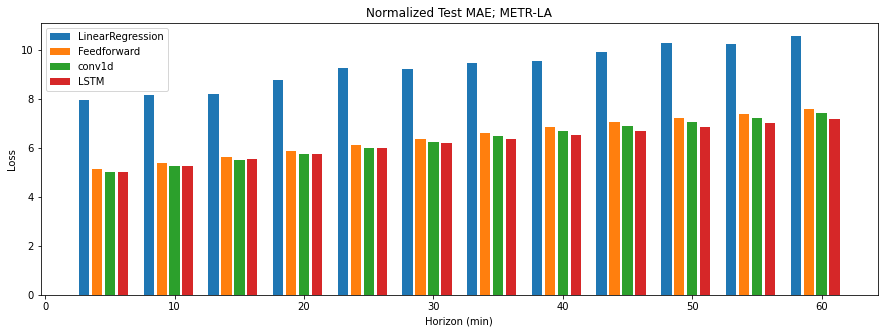

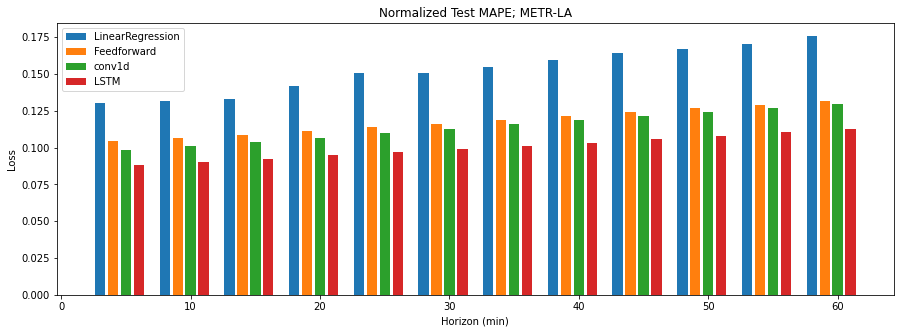

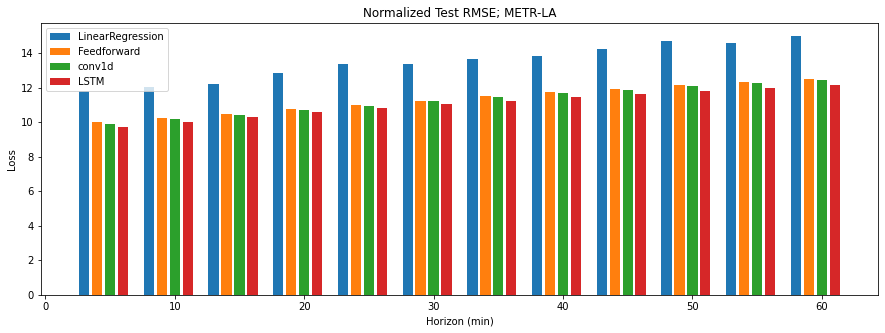

In [3]:
# Loss comparisons

def mae_losses(preds,labels):
    return np.mean(np.abs(preds-labels),axis=(0,2))[:,0]

def mape_losses(preds,labels):
    return np.mean(np.abs(np.divide(preds-labels,labels,
                                    out=np.zeros_like(preds), 
                                    where=labels!=0)),axis=(0,2))[:,0]

def rmse_losses(preds,labels):
    return np.mean(np.sqrt(np.mean(np.square(preds-labels),axis=2)),axis=0)[:,0]


loss_funcs = {'MAE':mae_losses,
              'MAPE':mape_losses,
              'RMSE':rmse_losses}

for loss in loss_funcs:

    plt.figure(figsize=(15,5))
    plt.title("Normalized Test "+loss+"; "+DATASET_NAME)
    
    for i,MODEL_NAME in enumerate(MODEL_NAMES):
        losses = loss_funcs[loss](run_info[MODEL_NAME]['predictions']['test'],data['y_test'])
        plt.bar(np.arange(1,13)*5+(i-len(MODEL_NAMES)//2),losses,label=MODEL_NAME)

    plt.xlabel("Horizon (min)")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(PLOTS_DIRECTORY,loss+'_comparison_'+DATASET_NAME+'.png'))

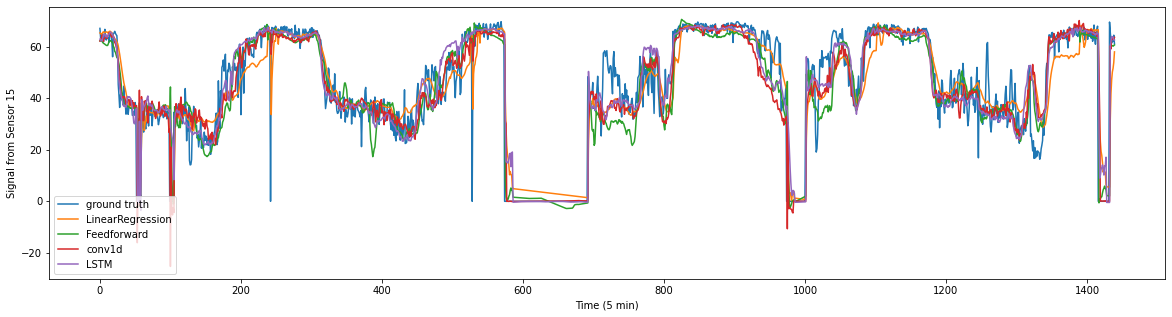

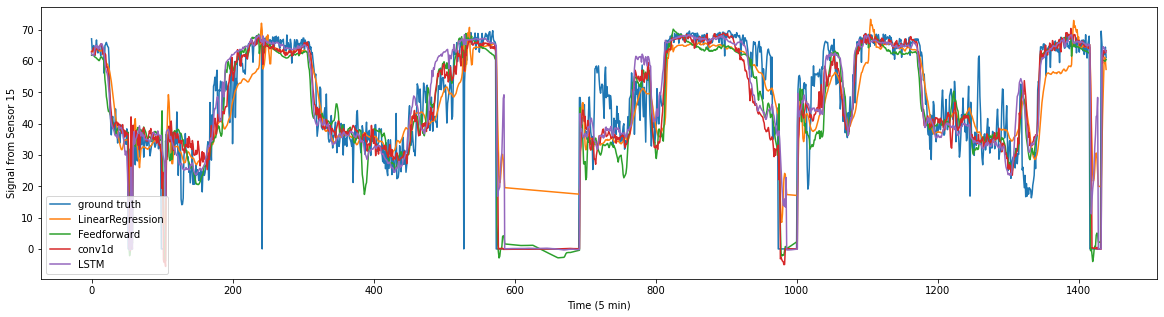

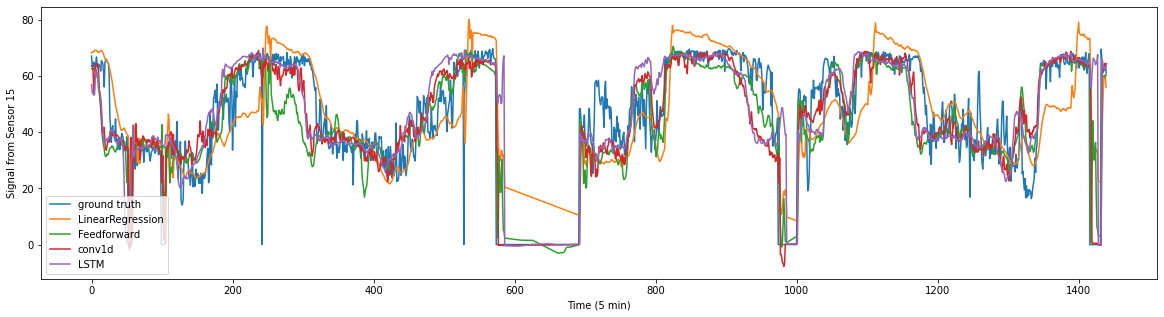

In [15]:
sensor_no = 15

for horizon in [0,2,11]:
    
    plt.figure(figsize=(20,5))
    plt.plot(data['y_test'][288*3:288*8,0,15,0],label='ground truth')
    plt.xlabel("Time (5 min)")
    plt.ylabel("Signal from Sensor {}".format(sensor_no))

    for MODEL_NAME in MODEL_NAMES:
        plt.plot(run_info[MODEL_NAME]['predictions']['test'][288*3:288*8,horizon,15,0],label=MODEL_NAME)
        
        
    plt.legend()
    plt.savefig(os.path.join(PLOTS_DIRECTORY,'horizon_'+str(horizon+1)+'_'+DATASET_NAME+'.png'))